In [ ]:
#imports
import tensorflow
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import Add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, GRU
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import random
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
#Provjera je li nam omogućena grafička kartica i CUDA platforma
!nvidia-smi

Thu Feb  4 04:10:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Skidanje podataka

In [ ]:
#Putanje do dataseta
dataset_text = "Flickr_8k_text"
dataset_images = "Flicker8k_Dataset"
glove_dir = 'glove'

In [ ]:
#Skidanje opisa
annotation_folder = '/Flickr_8k_text/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tensorflow.keras.utils.get_file('Flickr8k_text.zip',
                                          cache_subdir=os.path.abspath('.' + annotation_folder),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/Flickr8k_text/Flickr8k_text.json'
  os.remove(annotation_zip)

2342912/2340801 [==============================] - 0s 0us/step


In [ ]:
#Skidanje slika
image_folder = '/Flicker8k_Dataset/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tensorflow.keras.utils.get_file('Flickr8k_Dataset.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

1115422720/1115419746 [==============================] - 14s 0us/step


In [ ]:
#Skidanje Glove WordVec
glove_folder = '/glove/'
if not os.path.exists(os.path.abspath('.') + glove_folder):
  glove_zip = tensorflow.keras.utils.get_file('glove.6b.zip',
                                      cache_subdir=os.path.abspath('.'+ glove_folder),
                                      origin = 'https://nlp.stanford.edu/data/wordvecs/glove.6B.zip',
                                      extract = True)
  PATH = os.path.dirname(glove_zip) + glove_folder
  os.remove(glove_zip)

862183424/862182753 [==============================] - 388s 0us/step


Obrada tekstualnih podataka

In [ ]:
#Uređivanje tekstualnih podataka
#1Učitavanje datoteke u memoriju
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

#2 Riječnik koji spaja slike s njihovim opisima
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#3Pročiščavanje teksta, uklanjanje interpunkcija i brojeva
def preprocess_text(captions):
    punct = str.maketrans('','',string.punctuation)
    for photo,caption in captions.items():
        for i,img_caption in enumerate(caption):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            desc = [word.lower() for word in desc]
            #ukloni interpunkciju
            desc = [word.translate(punct) for word in desc]
            #uklanjanje riječi od jednog slova
            desc = [word for word in desc if(len(word)>1)]
            #uklanjanje brojeva
            desc = [word for word in desc if(word.isalpha())]

            img_caption = ' '.join(desc)
            captions[photo][i]= img_caption
    return captions

# 4Kreiranje vokabulara
def vocabulary(desc):
    vocab = set()
    for key in desc.keys():
        [vocab.update(d.split()) for d in desc[key]]
    return vocab

#5Grupiranje svih opisa u jednu datoteku 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


token_filepath= dataset_text + "/" + "Flickr8k.token.txt"
descriptions = all_img_captions(token_filepath)
print("Broj opisa slika =" ,len(descriptions))

clean_descriptions = preprocess_text(descriptions)
vocabulary = vocabulary(clean_descriptions)
print("Broj rijeci u vokabularu = ", len(vocabulary))

#Spremanje opisa u zasebnu datoteku 
save_descriptions(clean_descriptions, "descriptions.txt")

Broj opisa slika = 8092
Broj rijeci u vokabularu =  8763


In [ ]:
#Pretvaramo rjecnik u listu za tokenizaciju
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#Tokeniziramo sve opise  

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

#Najdulji opis slike
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)


#6
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

#7
def load_processed_descriptions(filename, photos): 
    #Radimo rjecnik slike povezan s prociscenim opisima. Dodajemo pocetni i krajnji token kako bi mreza znala pocetak i kraj pojedinog opisa
    #i da imamo pocetno stanje
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = 'starttoken ' + " ".join(image_caption) + ' endtoken'
            descriptions[image].append(desc)
    return descriptions

filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_processed_descriptions("descriptions.txt", train_imgs)
#Spremamo u posebnu datoteku
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1


    
maxlength = max_length(train_descriptions)
print('Vokabular= ' + str(vocab_size), 'Najdulji opis:' + str(maxlength))

Vokabular= 7579 Najdulji opis:34


Obrada slika i izvlačenje značajki

In [ ]:
#Procesiranje slika
def preprocess(image_path):
    #Inception model trazi slike velicine 299*299
    img = load_img(image_path, target_size=(299, 299))
    # Pretvaramo u numpyarray
    v = img_to_array(img)
    # Dodajemo dimenziju u naš array jer Inception očekuje input s 3 dimenzije
    v = np.expand_dims(v, axis=0)
    #koristimo modul koji slika prilagođava Inception modelu
    v = preprocess_input(v)
    return v

#funkcija za izvlacenje značajki svih slika koja vrača vektor značajki s 2048 dimenzija
def extract_features(directory):
  #Koristimo model Inception V3 bez potpuno poveznaog zadnjeg sloja. Time dobivamo 1*1*2048 vektor značajki
        model = InceptionV3( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image=preprocess(filename)
            feature = model.predict(image)
            features[img] = feature
        return features

In [ ]:
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
features=load(open('features.p', 'rb'))

In [ ]:
#Filtriramo znacajke koje pripadaju određenom setu podataka(train,test,val) 
def filter_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features



train_features = filter_features(train_imgs)

In [ ]:
#Smanjujemo vokabular na rijeci koje su koristene vise od 5 puta
all_train_captions = []
word_count_threshold = 5
word_counts = {}
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
        for w in cap.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
print("Broj svih opisa namjenjenih za treniranje: " + str(len( all_train_captions)))
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Vokabular prije i poslije: %d -> %d' % (len(word_counts), len(vocab)))
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(vocab)
tokenizer=tokenizer2
vocab_size = len(tokenizer.word_index) + 1

Broj svih opisa namjenjenih za treniranje: 30000
Vokabular prije i poslije: 7578 -> 2530


In [ ]:
word_counts['cat']

41

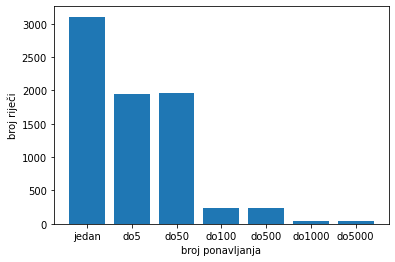

In [ ]:
td =	{
  "jedan": 0,
  "do5": 0,
  "do50": 0,
  "do100": 0,
  "do500": 0,
  "do1000": 0,
  "do5000": 0
}
for word, count in word_counts.items():
  if count <= 1:
    td["jedan"] = td.get("jedan", 0) + 1
  elif count < 5:
    td["do5"] = td.get("do5", 0) + 1
  elif count < 50:
    td["do50"] = td.get("do50", 0) + 1
  elif count < 100:
    td["do100"] = td.get("do100", 0) + 1
  elif count < 500:
    td["do500"] = td.get("do500", 0) + 1
  elif count < 1000:
    td["do1000"] = td.get("do1000", 0) + 1
  else:
    td["do5000"] = td.get("do5000", 0) + 1

plt.bar(*zip(*td.items()))
plt.xlabel("broj ponavljanja")
plt.ylabel("broj riječi")
plt.show()

In [ ]:
#Koristimo generator jer ne mogu drzati sve feature zajedno sa slikama u radnoj memoriji
def data_generator(descriptions, photos, tokenizer, maxlength, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # za svaku sliku napravimo batch podataka
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key][0]
            #Slijed koji sadrzi sliku, dosada vec predivdeni tekst koji vracamo natrag u model i sljedecu preidkciju rijeci
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=maxlength)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
#Učitavanje glove vektora
emb_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")
#Za svaku liniju u datoteci
for line in f:
    val = line.split()
    w = val[0]
    vec = np.asarray(val[1:], dtype='float32')
    emb_index[w] = vec
f.close()
print('Broj rijeci u Glove bazi %s ' % len(emb_index))

#Dimenzije Glove vektora
emb_dim = 300

#Radimo matricu koja povezuje rijeci iz naseg vokabulara s vektorima u glove bazi
#Matrica je velicine 2531 * 300 
emb_matrix = np.zeros((vocab_size, emb_dim))
#za svaku riječ u našem vokabularu 
for word, i in tokenizer.word_index.items():
    emb_vector = emb_index.get(word)
    if emb_vector is not None:
        emb_matrix[i] = emb_vector

Broj rijeci u Glove bazi 400001 


In [ ]:
# Definiranje modela neuralne mreze
def define_model(vocab_size, maxlength):

    #slojevi vezani za značajke slike
    #Inception daje vektor velicine 2048
    input1 = Input(shape=(2048,))
    #Dropout sloj na ulaznim podacima za srpjecavanje pretreniranja
    drop1 = Dropout(0.5)(input1)
    #Potpuno povezani sloj
    pp1 = Dense(256, activation='relu')(drop1)

    #slojevi vezani za kodiranje sekvenci opisa
    #Input nam je duljine najduzeg opisa. 
    input2 = Input(shape=(maxlength,))
    #Embedding sloj koji ugrađuje vektore iz GloVe modela, ignorira nule 
    em = Embedding(vocab_size, emb_dim, mask_zero=True, trainable=False)(input2)
    drop2 = Dropout(0.5)(em)
    gru = GRU(256)(drop2)

    #Spajamo dva inputa u jedan i povezujemo na dekoder
    dekoder1 = Add()([pp1, gru])
    dekoder2 = Dense(256, activation='relu')(dekoder1)
    outputs = Dense(vocab_size, activation='softmax')(dekoder2)

    model = Model(inputs=[input1, input2], outputs=outputs)
    #Postavljamo težine u modelu na težine iz glove vektora za svaku rijec 
    model.layers[2].set_weights([emb_matrix])
    #Zamrzavamo taj sloj kako ga treniranje ne bi mjenjalo
    model.layers[2].trainable = False
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Prikaz modela
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
model = define_model(vocab_size, maxlength)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      759300      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
val_filepath = 'model_val.h5'
checkpoint = ModelCheckpoint(val_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#ucitavamo validation set podataka
filename = 'Flickr_8k_text/Flickr_8k.devImages.txt'
val_imgs = load_photos(filename)
val = filter_features(val_imgs)
print('Dataset: %d' % len(val))
val_descriptions = load_processed_descriptions('descriptions.txt', val_imgs)
print('Descriptions: val=%d' % len(val_descriptions))
val_features = filter_features(val)
print('Photos: val=%d' % len(val_features))

Dataset: 1000
Descriptions: val=1000
Photos: val=1000


In [ ]:
epochs = 10
batch_size = 100
steps = len(train_descriptions)//batch_size
validation_steps=len(val_descriptions)//batch_size
loss_plot=[]
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, maxlength, batch_size)
    val_generator=data_generator(val_descriptions, val_features, tokenizer, maxlength, batch_size)
    hist=model.fit(generator, epochs=1, steps_per_epoch=steps,callbacks=[checkpoint],validation_data=val_generator,
                   validation_steps=validation_steps ,verbose=1)
    loss_plot.append(hist)
    model.save('./model_weights/model_' + str(i) + '.h5')

60/60 [==============================] - 31s 457ms/step - loss: 6.0584 - val_loss: 4.6810

Epoch 00001: val_loss improved from inf to 4.68100, saving model to model_val.h5
60/60 [==============================] - 27s 443ms/step - loss: 4.3952 - val_loss: 4.0506

Epoch 00001: val_loss improved from 4.68100 to 4.05063, saving model to model_val.h5
60/60 [==============================] - 26s 438ms/step - loss: 3.9285 - val_loss: 3.7584

Epoch 00001: val_loss improved from 4.05063 to 3.75842, saving model to model_val.h5
60/60 [==============================] - 26s 436ms/step - loss: 3.6657 - val_loss: 3.6070

Epoch 00001: val_loss improved from 3.75842 to 3.60703, saving model to model_val.h5
60/60 [==============================] - 26s 438ms/step - loss: 3.4972 - val_loss: 3.5018

Epoch 00001: val_loss improved from 3.60703 to 3.50177, saving model to model_val.h5
60/60 [==============================] - 26s 441ms/step - loss: 3.3703 - val_loss: 3.4376

Epoch 00001: val_loss improved fr

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
batch_size = 6
steps = len(train_descriptions)//batch_size
val_steps=len(val_descriptions)//batch_size
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, maxlength, batch_size)
    val_generator=data_generator(val_descriptions, val_features, tokenizer, maxlength, batch_size)
    hist=model.fit(generator, epochs=1, steps_per_epoch=steps,callbacks=[checkpoint],validation_data=val_generator, validation_steps=validation_steps, verbose=1)
    loss_plot.append(hist)

1000/1000 [==============================] - 109s 109ms/step - loss: 2.9849 - val_loss: 3.1725

Epoch 00001: val_loss improved from 3.29246 to 3.17248, saving model to model_val.h5
1000/1000 [==============================] - 111s 111ms/step - loss: 2.9313 - val_loss: 3.1658

Epoch 00001: val_loss improved from 3.17248 to 3.16579, saving model to model_val.h5
1000/1000 [==============================] - 106s 106ms/step - loss: 2.9016 - val_loss: 3.1635

Epoch 00001: val_loss improved from 3.16579 to 3.16347, saving model to model_val.h5
1000/1000 [==============================] - 110s 110ms/step - loss: 2.8795 - val_loss: 3.1583

Epoch 00001: val_loss improved from 3.16347 to 3.15829, saving model to model_val.h5
1000/1000 [==============================] - 107s 107ms/step - loss: 2.8563 - val_loss: 3.1537

Epoch 00001: val_loss improved from 3.15829 to 3.15370, saving model to model_val.h5
1000/1000 [==============================] - 108s 108ms/step - loss: 2.8353 - val_loss: 3.1527


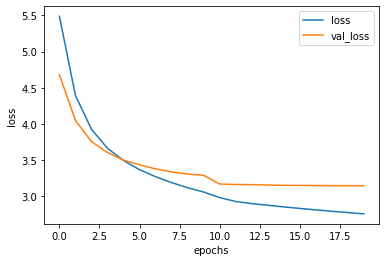

In [ ]:
loss=[]
val_loss=[]
for x in loss_plot:
  loss.append(x.history['loss'])
  val_loss.append(x.history['val_loss'])
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model.save_weights('./model_weights/model_zadnji.h5')

In [ ]:
model.load_weights('model_weights/model_zadnji.h5')

In [ ]:
model_val=define_model(vocab_size,maxlength)
model_val.load_weights('model_val.h5')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      759300      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
def prediction(photo_feature,model):
    text = 'starttoken'
    for i in range(maxlength):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence], maxlen=maxlength)
        index_pred_word = model.predict([photo_feature,sequence], verbose=0)
        index_pred_word = np.argmax(index_pred_word)
        word = tokenizer.index_word[index_pred_word]
        text += ' ' + word
        if word == 'endtoken':
            break
    final = text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
model_original = InceptionV3( include_top=False, pooling='avg' )


def encode_single(slika):
    slika = preprocess(slika)
    fea_vec = model_original.predict(slika) # Vektor značajki za jednu sliku
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


In [ ]:
def beam_search(model, tokenizer, image, maxlength, beam_index=3):
	in_text = [[tokenizer.texts_to_sequences(['starttoken'])[0], 0.0]]
	while len(in_text[0][0]) < maxlength:
		tempList = []
		for seq in in_text:
			padded_seq = pad_sequences([seq[0]], maxlen=maxlength)
			preds = model.predict([image,padded_seq], verbose=0)
			# Uzimamo 5 indeksa riječi s najvećom vjerojatnoscu
			top_preds = np.argsort(preds[0])[-beam_index:]
			# Getting the top `beam_index` predictions and 
			for word in top_preds:
				next_seq, prob = seq[0][:], seq[1]
				next_seq.append(word)
				# Zbrajamo vjerojatnosti
				prob += preds[0][word]
				# Dodajemo sekvencu kao ulaz za sljedecu riječ
				tempList.append([next_seq, prob])
		in_text = tempList
		# Sortiramo prema zbroju vjerojatnosti
		in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
		# Uzimamo top n riječi
		in_text = in_text[-beam_index:]
	in_text = in_text[-1][0]
	final_caption_raw = [tokenizer.index_word[i] for i in in_text]
	final_caption = []
	for word in final_caption_raw:
		if word=='endtoken':
			break
		else:
			final_caption.append(word)
	final_caption.append('endtoken')
	final = final_caption[1:-1]
	return ' '.join(final)



In [ ]:
#Test slike flickr8k
filename = dataset_text + "/" + "Flickr_8k.testImages.txt"
test_imgs = load_photos(filename)
test_descriptions = load_processed_descriptions("descriptions.txt", test_imgs)
test_features = filter_features(test_imgs)
images = 'Flicker8k_Dataset/'
beam_index=5

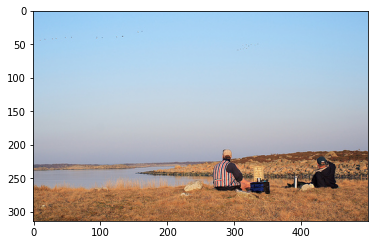

Predction zadnji: two people are walking along the beach
Predction val: two people are walking along the beach
Beam search zadnji: two people stand on the beach near the ocean
Beam search validation:: two people stand on the beach near the ocean


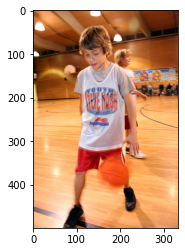

Predction zadnji: boy in blue shorts and blue shorts is standing on the floor
Predction val: boy in blue shorts and blue shorts is standing on the floor
Beam search zadnji: little boy in blue shorts is standing on basketball court
Beam search validation:: little boy in blue shorts is standing on basketball court


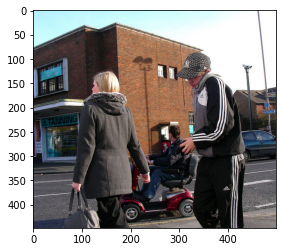

Predction zadnji: man in black jacket and hat is sitting on the sidewalk
Predction val: man in black jacket and hat is sitting on the sidewalk
Beam search zadnji: man and woman walking down street
Beam search validation:: man and woman walking down street


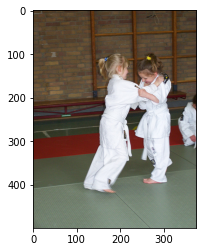

Predction zadnji: two girls are playing with ball
Predction val: two girls are playing with ball
Beam search zadnji: group of people are standing in front of building
Beam search validation:: group of people are standing in front of building


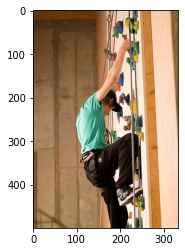

Predction zadnji: boy in red shirt is jumping off of the stairs
Predction val: boy in red shirt is jumping off of the stairs
Beam search zadnji: the boy is performing trick on his skateboard
Beam search validation:: the boy is performing trick on his skateboard


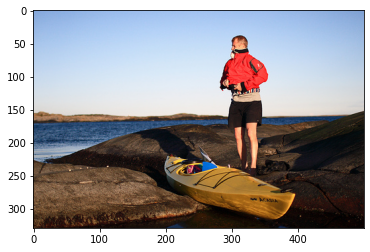

Predction zadnji: man in black shirt is standing on top of rock
Predction val: man in black shirt is standing on top of rock
Beam search zadnji: man is standing on top of cliff overlooking the ocean
Beam search validation:: man is standing on top of cliff overlooking the ocean


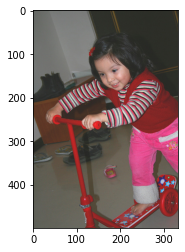

Predction zadnji: little boy in red shirt and blue shirt is riding red and red toy
Predction val: little boy in red shirt and blue shirt is riding red and red toy
Beam search zadnji: little boy in red shirt is playing on the playground
Beam search validation:: little boy in red shirt is playing on the playground


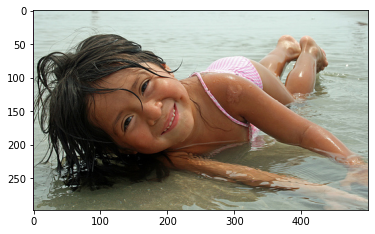

Predction zadnji: two girls are playing in the water
Predction val: two girls are playing in the water
Beam search zadnji: little girl in bathing suit plays in the water
Beam search validation:: little girl in bathing suit plays in the water


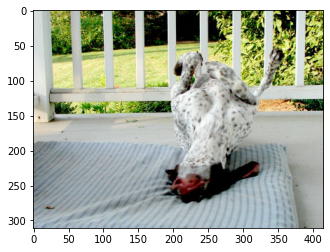

Predction zadnji: dog is running through the grass
Predction val: dog is running through the grass
Beam search zadnji: black and white dog jumps over hurdle
Beam search validation:: black and white dog jumps over hurdle


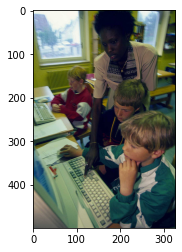

Predction zadnji: woman in black shirt is sitting on the sidewalk
Predction val: woman in black shirt is sitting on the sidewalk
Beam search zadnji: man and woman sit in front of restaurant
Beam search validation:: man and woman sit in front of restaurant


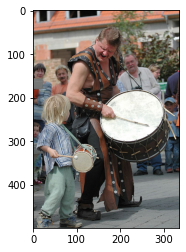

Predction zadnji: man in white shirt and black hat is standing in front of crowd
Predction val: man in white shirt and black hat is standing in front of crowd
Beam search zadnji: the man in the red shirt is standing in front of crowd
Beam search validation:: the man in the red shirt is standing in front of crowd


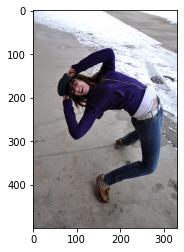

Predction zadnji: girl in red shirt is climbing up rock
Predction val: girl in red shirt is climbing up rock
Beam search zadnji: young girl in red shirt is climbing rock wall
Beam search validation:: young girl in red shirt is climbing rock wall


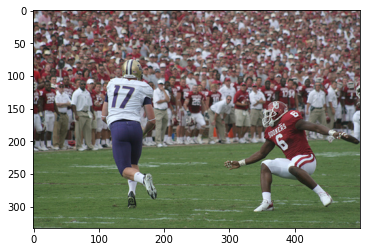

Predction zadnji: two men in white uniforms are playing football
Predction val: two men in white uniforms are playing football
Beam search zadnji: group of football players playing football
Beam search validation:: group of football players playing football


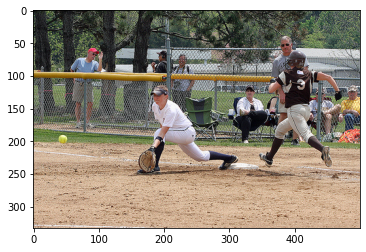

Predction zadnji: two boys playing baseball
Predction val: two boys playing baseball
Beam search zadnji: two young boys are playing soccer on the grass
Beam search validation:: two young boys are playing soccer on the grass


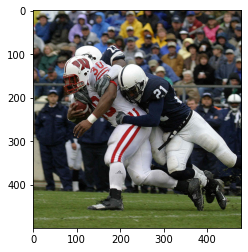

Predction zadnji: two football players are tackling the ball
Predction val: two football players are tackling the ball
Beam search zadnji: group of football players are tackling the ball
Beam search validation:: group of football players are tackling the ball


In [ ]:
for i in range(15):
  random_number=random.randint(0,len(test_features)-1)
  pic_id=list(test_features.keys())[random_number]
  image = test_features[pic_id].reshape((1,2048))
  x=plt.imread(images + pic_id)
  plt.imshow(x)
  plt.show()
  print("Predction zadnji:",prediction(image,model))
  print("Predction val:",prediction(image,model_val))
  print("Beam search zadnji:",beam_search(model, tokenizer, image, maxlength,beam_index))
  print("Beam search validation::",beam_search(model_val, tokenizer, image, maxlength,beam_index))

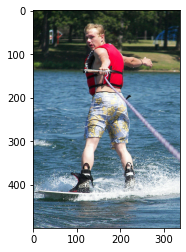

Predction zadnji: man in red bathing suit is swinging in the water
Predction val: man in red bathing suit is swinging in the water
Beam search zadnji k=5: girl in pink bathing suit is jumping into the water
Beam search validation k = 5: girl in pink bathing suit is jumping into the water
Beam search zadnji k=7: girl in pink bathing suit is jumping into the water
Beam search validation k=7: girl in pink bathing suit is jumping into the water
Beam search zadnji k=10: girl in pink bathing suit is jumping into the water
Beam search validation k=10: girl in pink bathing suit is jumping into the water


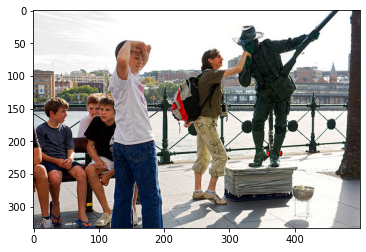

Predction zadnji: woman in red shirt and jeans is walking down the sidewalk
Predction val: woman in red shirt and jeans is walking down the sidewalk
Beam search zadnji k=5: girl in red shirt is walking down the street
Beam search validation k = 5: girl in red shirt is walking down the street
Beam search zadnji k=7: little girl is walking on the sidewalk next to building
Beam search validation k=7: little girl is walking on the sidewalk next to building
Beam search zadnji k=10: little girl is walking on the sidewalk next to building
Beam search validation k=10: little girl is walking on the sidewalk next to building


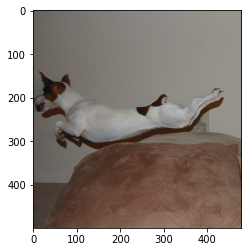

Predction zadnji: two dogs are playing with ball
Predction val: two dogs are playing with ball
Beam search zadnji k=5: brown and white dog is playing with ball
Beam search validation k = 5: brown and white dog is playing with ball
Beam search zadnji k=7: brown and white dog is playing with ball
Beam search validation k=7: brown and white dog is playing with ball
Beam search zadnji k=10: brown and white dog is playing with ball
Beam search validation k=10: brown and white dog is playing with ball


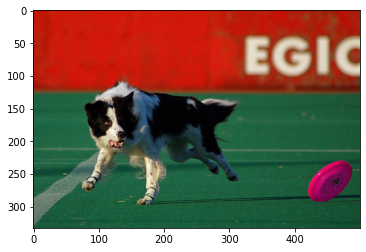

Predction zadnji: dog runs across the grass
Predction val: dog runs across the grass
Beam search zadnji k=5: black and white dog jumps to catch frisbee
Beam search validation k = 5: black and white dog jumps to catch frisbee
Beam search zadnji k=7: black and white dog jumping to catch frisbee
Beam search validation k=7: black and white dog jumping to catch frisbee
Beam search zadnji k=10: black and white dog jumping to catch frisbee
Beam search validation k=10: black and white dog jumping to catch frisbee


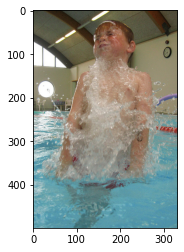

Predction zadnji: boy in swimming trunks is splashing in pool
Predction val: boy in swimming trunks is splashing in pool
Beam search zadnji k=5: young boy is splashing in pool
Beam search validation k = 5: young boy is splashing in pool
Beam search zadnji k=7: young boy splashing in pool
Beam search validation k=7: young boy splashing in pool
Beam search zadnji k=10: young boy splashing in pool
Beam search validation k=10: young boy splashing in pool


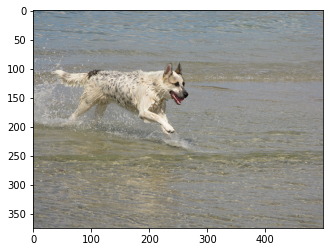

Predction zadnji: dog runs through the water
Predction val: dog runs through the water
Beam search zadnji k=5: black and white dog runs through the water
Beam search validation k = 5: black and white dog runs through the water
Beam search zadnji k=7: black and white dog runs through the water
Beam search validation k=7: black and white dog runs through the water
Beam search zadnji k=10: black and white dog runs through the water
Beam search validation k=10: black and white dog runs through the water


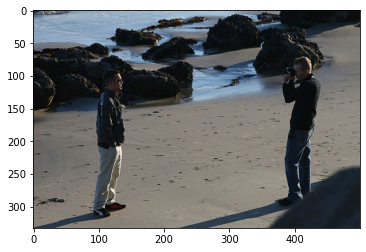

Predction zadnji: two people are walking along the beach
Predction val: two people are walking along the beach
Beam search zadnji k=5: two people are walking along the beach
Beam search validation k = 5: two people are walking along the beach
Beam search zadnji k=7: two people are walking along the beach
Beam search validation k=7: two people are walking along the beach
Beam search zadnji k=10: two people are walking along the beach
Beam search validation k=10: two people are walking along the beach


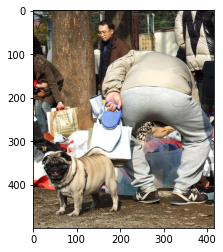

Predction zadnji: two women in black and white robes are sitting on the ground
Predction val: two women in black and white robes are sitting on the ground
Beam search zadnji k=5: young boy is sitting on bench in front of crowd
Beam search validation k = 5: young boy is sitting on bench in front of crowd
Beam search zadnji k=7: young boy sits on top of bench
Beam search validation k=7: young boy sits on top of bench
Beam search zadnji k=10: young boy sits on top of bench
Beam search validation k=10: young boy sits on top of bench


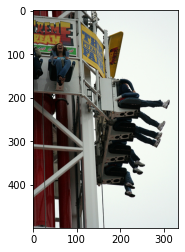

Predction zadnji: man in black shirt and jeans is standing on top of white building
Predction val: man in black shirt and jeans is standing on top of white building
Beam search zadnji k=5: the man in the red shirt is standing next to car
Beam search validation k = 5: the man in the red shirt is standing next to car
Beam search zadnji k=7: man and woman are standing in front of bus
Beam search validation k=7: man and woman are standing in front of bus
Beam search zadnji k=10: man and woman are standing in front of bus
Beam search validation k=10: man and woman are standing in front of bus


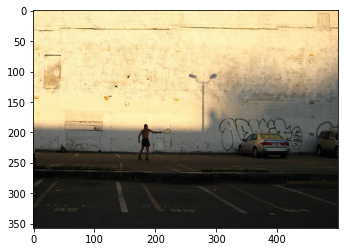

Predction zadnji: man in white shirt is walking along the street
Predction val: man in white shirt is walking along the street
Beam search zadnji k=5: two people are walking on the beach
Beam search validation k = 5: two people are walking on the beach
Beam search zadnji k=7: two people are walking on the beach
Beam search validation k=7: two people are walking on the beach
Beam search zadnji k=10: two people are walking on the beach
Beam search validation k=10: two people are walking on the beach


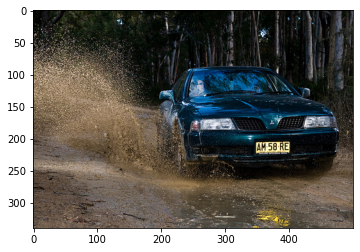

Predction zadnji: car drives through the mud
Predction val: car drives through the mud
Beam search zadnji k=5: the car is driving through the mud
Beam search validation k = 5: the car is driving through the mud
Beam search zadnji k=7: the car is driving in the mud
Beam search validation k=7: the car is driving in the mud
Beam search zadnji k=10: the car is driving in the mud
Beam search validation k=10: the car is driving in the mud


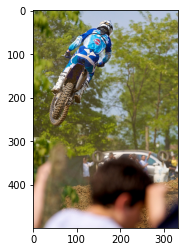

Predction zadnji: man in red shirt is riding bike
Predction val: man in red shirt is riding bike
Beam search zadnji k=5: man is riding bicycle through the woods
Beam search validation k = 5: man is riding bicycle through the woods
Beam search zadnji k=7: mountain biker does trick in the air
Beam search validation k=7: mountain biker does trick in the air
Beam search zadnji k=10: mountain biker does trick in the air
Beam search validation k=10: mountain biker does trick in the air


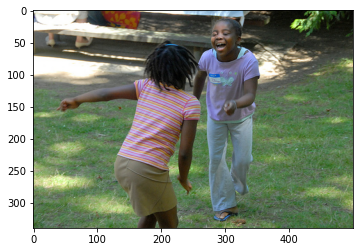

Predction zadnji: little boy in red shirt is running through the grass
Predction val: little boy in red shirt is running through the grass
Beam search zadnji k=5: little boy runs through the grass
Beam search validation k = 5: little boy runs through the grass
Beam search zadnji k=7: little boy runs through the grass
Beam search validation k=7: little boy runs through the grass
Beam search zadnji k=10: little boy runs through the grass
Beam search validation k=10: little boy runs through the grass


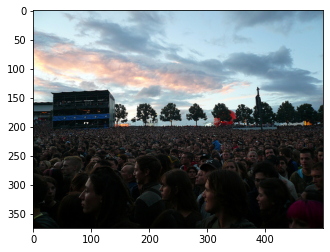

Predction zadnji: group of people are standing in line of crowd
Predction val: group of people are standing in line of crowd
Beam search zadnji k=5: group of people are standing in front of crowd


In [ ]:
beam_index=5
beam_index2=7
beam_index3=7
for i in range(15):
  random_number=random.randint(0,len(test_features)-1)
  pic_id=list(test_features.keys())[random_number]
  image = test_features[pic_id].reshape((1,2048))
  x=plt.imread(images + pic_id)
  plt.imshow(x)
  plt.show()
  print("Predction zadnji:",prediction(image,model))
  print("Predction val:",prediction(image,model_val))
  print("Beam search zadnji k=5:",beam_search(model, tokenizer, image, maxlength,beam_index))
  print("Beam search validation k = 5:",beam_search(model_val, tokenizer, image, maxlength,beam_index))
  print("Beam search zadnji k=7:",beam_search(model, tokenizer, image, maxlength,beam_index2))
  print("Beam search validation k=7:",beam_search(model_val, tokenizer, image, maxlength,beam_index2))
  print("Beam search zadnji k=10:",beam_search(model, tokenizer, image, maxlength,beam_index3))
  print("Beam search validation k=10:",beam_search(model_val, tokenizer, image, maxlength,beam_index3))

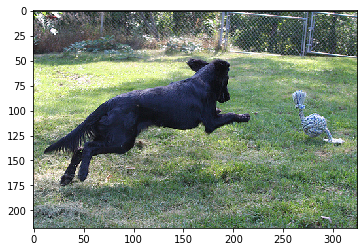

Predction mode30: black dog is running through the grass
Predction val: black dog is running through the grass
Beam search zadnji: black dog runs through the grass
Beam search validation: black dog runs through the grass


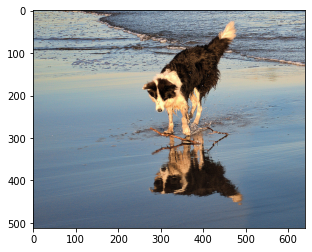

Predction mode30: black and white dog is running through the water
Predction val: black and white dog is running through the water
Beam search zadnji: black and white dog is running through the water
Beam search validation: black and white dog is running through the water


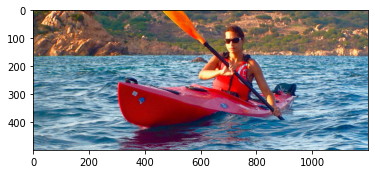

Predction mode30: man in yellow shirt and white shirt is paddling through the water
Predction val: man in yellow shirt and white shirt is paddling through the water
Beam search zadnji: the man is kayaking through lake
Beam search validation: the man is kayaking through lake


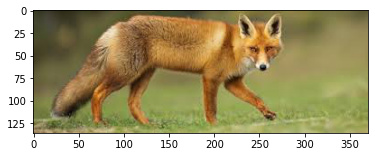

Predction mode30: two people are playing in the snow
Predction val: two people are playing in the snow
Beam search zadnji: young boy plays in the snow
Beam search validation: young boy plays in the snow


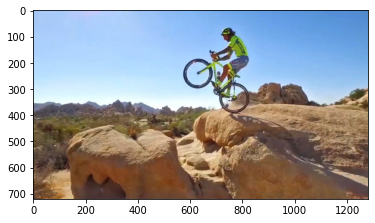

Predction mode30: man in red shirt is riding bike on the woods
Predction val: man in red shirt is riding bike on the woods
Beam search zadnji: man is riding bike through the woods
Beam search validation: man is riding bike through the woods


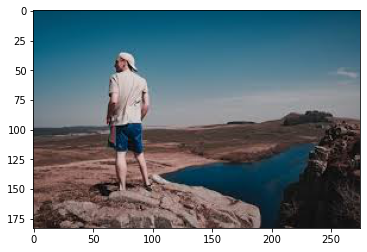

Predction mode30: man is standing on the edge of rocks
Predction val: man is standing on the edge of rocks
Beam search zadnji: group of people are standing on the edge of rocks
Beam search validation: group of people are standing on the edge of rocks


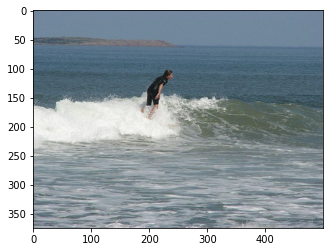

Predction mode30: man is surfing on the beach
Predction val: man is surfing on the beach
Beam search zadnji: the surfer is jumping into the ocean
Beam search validation: the surfer is jumping into the ocean


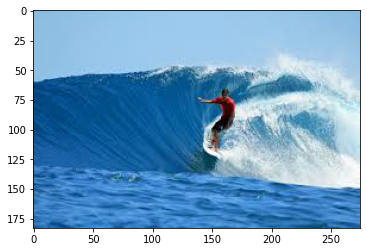

Predction mode30: surfer is surfing on the ocean
Predction val: surfer is surfing on the ocean
Beam search zadnji: the surfer is in the snow
Beam search validation: the surfer is in the snow


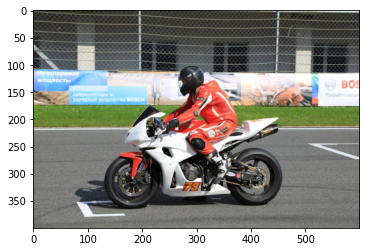

Predction mode30: man in red shirt and black helmet is riding his motorcycle
Predction val: man in red shirt and black helmet is riding his motorcycle
Beam search zadnji: man in red and white helmet is sitting on motorcycle
Beam search validation: man in red and white helmet is sitting on motorcycle


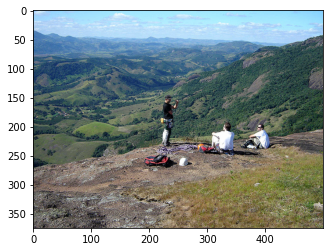

Predction mode30: man is sitting on the edge of rocky mountain
Predction val: man is sitting on the edge of rocky mountain
Beam search zadnji: group of people are sitting on mountain
Beam search validation: group of people are sitting on mountain


In [ ]:
#Slike s interneta
beam_index=5
slike_img=['dog.png','dogbeach.jpg','kayak.jpg','fox.jpg','bikestunt.jpg','manonrock.jpg','surfer.png','surfing.jpg','motor.jpg','proba.jpg']
encoding_slike = {}
for slika in slike_img:
    encoding_slike[slika[:]] = encode_single(slika)
for z in range(10):
  picc=list(encoding_slike.keys())[z]
  image = encoding_slike[picc].reshape((1,2048))
  x=plt.imread(picc)
  plt.imshow(x)
  plt.show()
  print("Predction:",prediction(image,model_val))
  print("Beam search validation:",beam_search(model_val, tokenizer, image, maxlength,beam_index))

In [ ]:
def blue_prediction(model, descriptions, photos, tokenizer, maxlength):
	real, predicted = list(), list()
	# Prolazimo kroz sve opise
	for key, desc_list in descriptions.items():
		# Generiramo opis
		pred = prediction(photos[key],model)
		# Spremamo predviđeni i stvarni
		references = [d.split() for d in desc_list]
		real.append(references)
		predicted.append(pred.split())
	print('BLEU-1: %f' % corpus_bleu(real, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(real, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(real, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(real, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
def bleu_beamsearch(model, descriptions, photos, tokenizer, maxlength,beam_index=3):
	real, predicted = list(), list()
	for key, desc_list in descriptions.items():
		#Generiramo opis
		pred = beam_search(model,tokenizer,photos[key],maxlength,beam_index)
		#Spremamo predviđeni i stvarni
		references = [d.split() for d in desc_list]
		real.append(references)
		predicted.append(pred.split())
	print('BLEU-1: %f' % corpus_bleu(real, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(real, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(real, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(real, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
print('Prediction model zadnji:')
blue_prediction(model, test_descriptions, test_features, tokenizer, maxlength)
print('Prediction model_val')
blue_prediction(model_val, test_descriptions, test_features, tokenizer, maxlength)

Prediction model zadnji:
BLEU-1: 0.466681
BLEU-2: 0.281227
BLEU-3: 0.198656
BLEU-4: 0.099561
Prediction model_val
BLEU-1: 0.466681
BLEU-2: 0.281227
BLEU-3: 0.198656
BLEU-4: 0.099561


In [ ]:
beam_index=7
print('Beam search model zadnji k=7:')
bleu_beamsearch(model, test_descriptions, test_features, tokenizer, maxlength,beam_index)
print('Beam search model_val k=7')
bleu_beamsearch(model_val, test_descriptions, test_features, tokenizer, maxlength, beam_index)